In [8]:
using NeutrinoTelescopes
using Flux
using CUDA
using Random
using StaticArrays
using BSON: @save, @load
using BSON
using CairoMakie
using Rotations
using LinearAlgebra
using DataFrames
using Zygote
using PoissonRandom
using SpecialFunctions
using StatsBase
using Base.Iterators
using Distributions
using Optim
using LogExpFunctions
using Base.Iterators
using Formatting

In [9]:
mutable struct ModelParam{T<:Number, LB<:Number, UB <:Number}
    name::String
    value::T
    active::Bool
    bounds::Tuple{LB, UB}
end

mutable struct Model
    params::Vector{ModelParam}
end

params(m::Model) = m.params
free_params(m::Model) = [p for p in params(m) if p.active]
get_lower_bounds(m::Model) = [p.bounds[1] for p in free_params(m)]
get_upper_bounds(m::Model) = [p.bounds[2] for p in free_params(m)]
get_seeds(m::Model) = [p.value for p in free_params(m)]

function get_param(m::Model, name::String)
    fp = nothing
    for p in params(m)
        if p.name == name
            fp = p
        end
    end

    if isnothing(fp)
        error("Parameter $name not found in model")
    end

    return fp
end

function set_inactive!(m::Model, name::String)
    p = get_param(m, name)
    p.active = false
end

function set_active!(m::Model, name::String)
    p = get_param(m, name)
    p.active = true
end

function parse_model_params(x, model)

    @assert length(x) == length(free_params(model))
    
    fix = 1
    mparams = params(model)

    parsed = []
    for par in mparams
        if mparams[fix].active
            val = x[fix]
            fix +=1
        else
            val = par.value
        end

        push!(parsed, val)
    end
    return parsed
end

function make_cascade_fit_model(;seed_log_energy=3., seed_zenith=0.5, seed_azimuth=0.5, seed_x=0., seed_y=0., seed_z=0., seed_time=0.)
    logenergy = ModelParam("logenergy", seed_log_energy, true, (2., 5.))
    zenith = ModelParam("zenith", seed_zenith, true, (0., π))
    
    azimuth = ModelParam("azimuth", seed_azimuth, true, (seed_azimuth-π, seed_azimuth+π))
    #azimuth = ModelParam("azimuth", seed_azimuth, true, (0., 2*π))
    pos_x = ModelParam("pos_x", seed_x, true, (-100., 100.))
    pos_y = ModelParam("pos_y", seed_y, true, (-100., 100.))
    pos_z = ModelParam("pos_z", seed_z, true, (100., -1000.))
    time = ModelParam("time", seed_time, true, (-50., 100.))
    return Model([logenergy, zenith, azimuth, pos_x, pos_y, pos_z, time])
end


make_cascade_fit_model (generic function with 1 method)

In [29]:
function min_lh(fit_model, data, targets, model, tf_vec, c_n; strategy=:cg)

    function _func(x)
        logenergy, theta, phi, pos_x, pos_y, pos_z, time = parse_model_params(x, fit_model)
        fval =  -single_cascade_likelihood(logenergy, theta, phi, SA[pos_x, pos_y, pos_z], time; data=data, targets=targets, model=model, tf_vec=tf_vec, c_n=c_n)
        return fval
    end

    
    lower = get_lower_bounds(fit_model)
    upper = get_upper_bounds(fit_model)
    seeds = get_seeds(fit_model)

    if strategy == :cg
        inner_optimizer = ConjugateGradient()
        algo = Fminbox(inner_optimizer) 
        results  = optimize(_func, lower, upper, seeds, algo; autodiff=:forward)
    elseif strategy == :annealing
        algo = SAMIN(rt=0.5)
        opt = Optim.Options(iterations=10^5)
        results  = optimize(_func, lower, upper, seeds, algo, opt)
    else
        error("Strategy $strategy unknown.")
    end
    
    return results
end

function calc_resolution_maxlh(targets, sampling_model, eval_model, n; energy=1E4, zenith=0.1, phi=0.1, position=SA[3., 10., 15.], time=0.)
    
    rng = MersenneTwister(31338)
    hypo = make_cascade_fit_model(seed_x=position[1], seed_y=position[2], seed_z=position[3], seed_time=time)
    set_inactive!(hypo, "pos_x")
    set_inactive!(hypo, "pos_y")
    set_inactive!(hypo, "pos_z")
    set_inactive!(hypo, "time")
    min_vals = []
    for _ in 1:n
        samples = sample_cascade_event(energy, zenith, phi, position, time; targets=targets, model=sampling_model[:model], tf_vec=sampling_model[:tf_dict], rng=rng)
        res = min_lh(hypo, samples, targets, eval_model[:model], eval_model[:tf_dict])    
        push!(min_vals, Optim.minimizer(res))
    end
    min_vals = reduce(hcat, min_vals)

    return min_vals
end

calc_resolution_maxlh(targets, model, n) = calc_resolution_maxlh(targets, model, model, n)



function mc_expectation(particles::AbstractVector{<:Particle}, targets::AbstractVector{<:MultiPMTDetector}, seed)
    
    wl_range = (300.0f0, 800.0f0)
    medium = make_cascadia_medium_properties(0.99f0)
    spectrum = CherenkovSpectrum(wl_range, 30, medium)

    sources = [ExtendedCherenkovEmitter(convert(Particle{Float32}, p), medium, wl_range) for p in particles]

    targets_c::Vector{MultiPMTDetector{Float32}} = targets

    photon_setup = PhotonPropSetup(sources, targets_c, medium, spectrum, seed)
    photons = propagate_photons(photon_setup)

    calc_total_weight!(photons, photon_setup)
    calc_time_residual!(photons, photon_setup)

    rot = RotMatrix3(I)
    hits = make_hits_from_photons(photons, photon_setup, rot)
    return hits
end


function compare_mc_model(
    particles::AbstractVector{<:Particle},
    targets::AbstractVector{<:PhotonTarget},
    models::Dict,
    medium::MediumProperties,
    hits)
    
    c_n = c_at_wl(800f0, medium)

    times = -50:1:150
    fig = Figure(resolution=(1500, 1000))
    ga = fig[1, 1] = GridLayout(4, 4)

    for i in 1:16
        row, col = divrem(i - 1, 4)
        mask = hits[:, :pmt_id] .== i
        ax = Axis(ga[col+1, row+1], xlabel="Time Residual(ns)", ylabel="Photons / time", title="PMT $i",
                  )
        hist!(ax, hits[mask, :tres], bins=-50:3:150, weights=hits[mask, :total_weight], color=:orange, normalization=:density,)
    end

    n_pmt = get_pmt_count(eltype(targets))

    t_geos = repeat([calc_tgeo(norm(particles[1].position - t.position) - t.radius, c_n) for t in targets], n_pmt)
    t0 = particles[1].time
    
    @load models["4"] model hparams opt tf_dict
    samples = sample_multi_particle_event(particles, targets, model, tf_dict, c_n, rng)
    tgeo = calc_tgeo(norm(particles[1].position - targets[1].position) - targets[1].radius, c_n)
    for i in 1:16
        row, col = divrem(i - 1, 4)
        hist!(ga[col+1, row+1], samples[i] .- tgeo .- t0 , bins=-50:5:150, normalization=:density, fillaplha=0.3)
    end

    for (mname, model_path) in models
        @load model_path model hparams opt tf_dict
        input = calc_flow_input(particles, targets, tf_dict)
        

        shape_lhs = []
        local log_expec
        for t in times
            _, shape_lh, log_expec = SurrogateModels.evaluate_model(particles, Vector.(eachrow(t .+ t_geos .+ t0)), targets, model, tf_dict, c_n)
            push!(shape_lhs, collect(shape_lh))
        end

        shape_lh = reduce(hcat, shape_lhs)

        for i in 1:16
            row, col = divrem(i - 1, 4)
            lines!(ga[col+1, row+1], times, exp.(shape_lh[i, :] .+ log_expec[i]), label=mname)
            
        end
    end

    fig
end

compare_mc_model(particles, targets, models) =  compare_mc_model(particles, targets, models, mc_expectation(particles, targets))

compare_mc_model (generic function with 2 methods)

# Setup
Load surrogate models and create a few detector configurations.

In [11]:
models = Dict(
    "1" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_1_FNL.bson"),
    "2" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_2_FNL.bson"),
    "3" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_3_FNL.bson"),
    "4" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_4_FNL.bson"),
    "5" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_5_FNL.bson"),
    #"FULL" => joinpath(@__DIR__, "../assets/rq_spline_model_l2_0_FULL_FNL.bson")
)
    
targets_single = [make_pone_module(@SVector[-25., 0., -450.], 1)]
targets_line = make_detector_line(@SVector[-25., 0.0, 0.0], 20, 50, 1)
targets_three_l = [
    make_detector_line(@SVector[-25., 0.0, 0.0], 20, 50, 1)
    make_detector_line(@SVector[25., 0.0, 0.0], 20, 50, 21)
    make_detector_line(@SVector[0., sqrt(50^2-25^2), 0.0], 20, 50, 41)]
targets_hex = make_hex_detector(3, 50, 20, 50, truncate=1)

detectors = Dict("Single" => targets_single, "Line" =>targets_line, "Tri" => targets_three_l, "Hex" => targets_hex)
medium = make_cascadia_medium_properties(0.99f0)


WaterProperties{Float32}(34.82f0, 265.91748f0, 1.8f0, 0.0075f0, 0.0075f0, 36.08f0, 1013.2627f0, 0.99f0, (1.3240297f0, 16.262556f0, -4382.0f0, 1.1455f6))

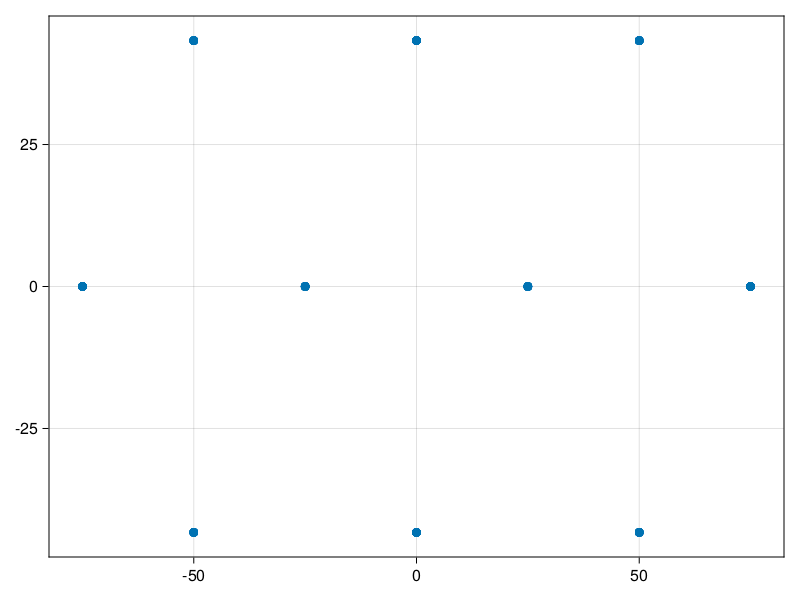

In [12]:
scatter(reduce(hcat, [t.position for t in targets_hex])[1:2, :])

# Surrogate model
Verify that the surrogate model can reproduce MC.

Create a rather complicated (non-physical) event consisting of multiple extended cascades,
rund photon MC and compare the detected photons to the expectation from the surrogate model.

In [6]:
pos = SA[8., -5., -450]
dir_theta = 0.7
dir_phi = 1.3
dir = sph_to_cart(dir_theta, dir_phi)
energy = 3e4

rng = MersenneTwister(31338)
particles = [
        Particle(pos, dir, 0., energy, PEMinus),
        Particle(pos .+ dir.*5, dir, 15, energy, PEMinus),
        Particle(pos .+ dir.*10, dir, 25, energy, PEMinus)
]

hits = mc_expectation(particles, targets_single, 1);

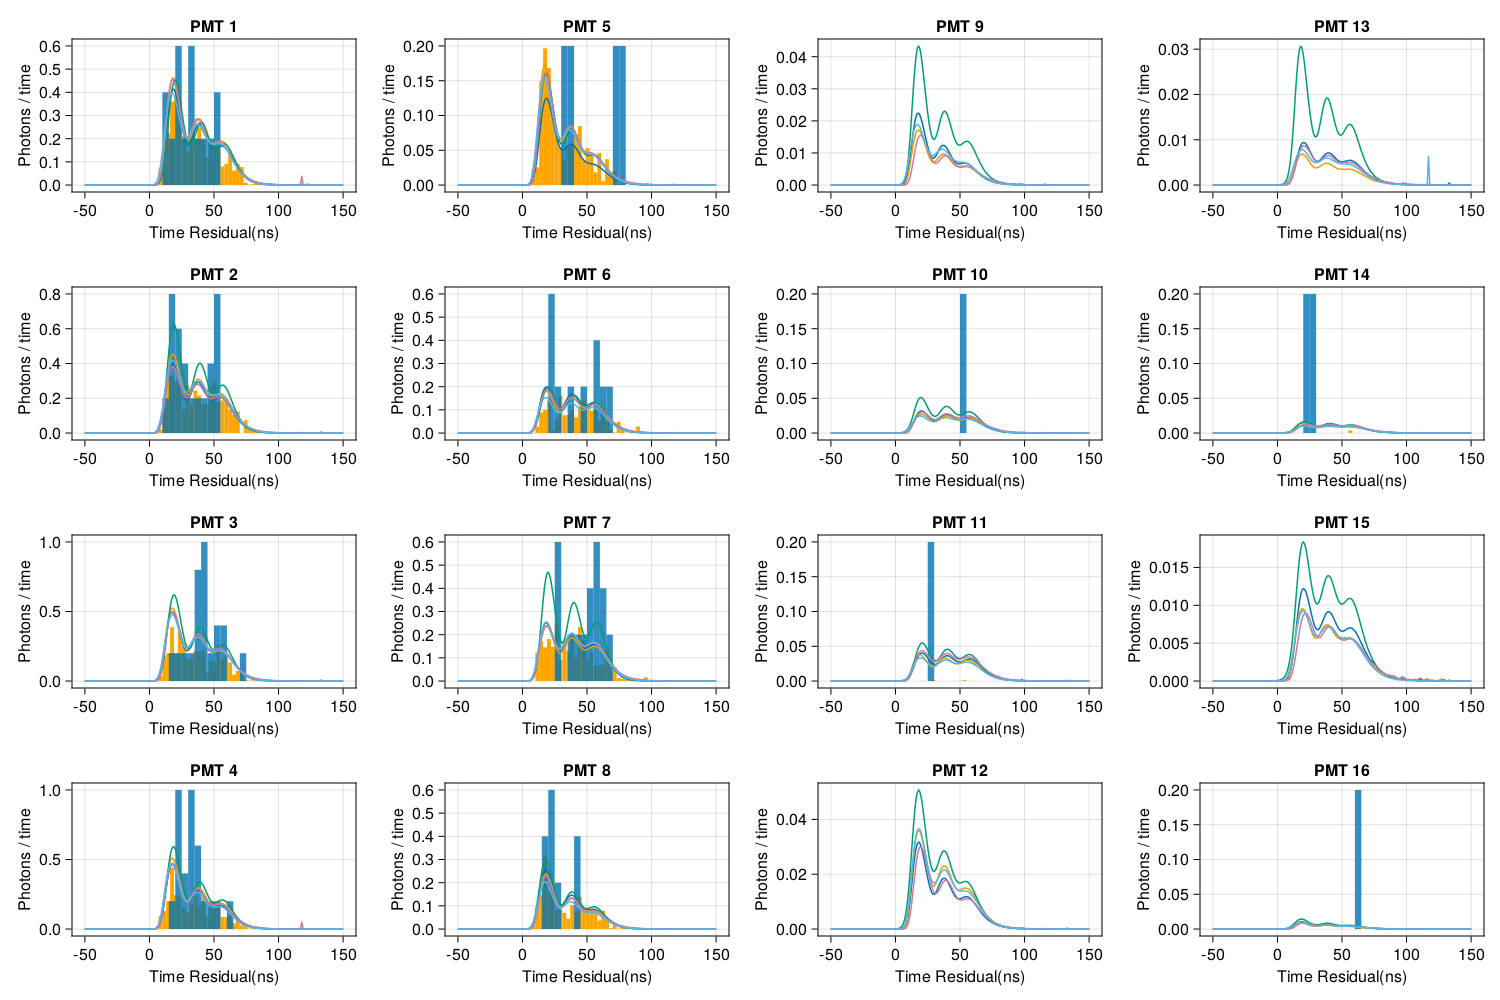

In [30]:
compare_mc_model(particles, targets_single, models, medium, hits)


# Likelihood
## Plots of likelihood scans for an example event.

Simulate an event for the different detector configs and plot 1D likelihood scans in energy, zenith and azimuth

In [26]:
@load models["4"] model hparams opt tf_dict

pos = SA[8., -5., -450]
theta = 0.5
phi = 0.4
rng = MersenneTwister(31338)
targets_range = [t for t in targets_hex if norm(t.position .- pos) < 200]

c_n = c_at_wl(800f0, medium)

samples = sample_cascade_event(5E4, theta, phi, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=rng, c_n=c_n)
hypo = make_cascade_fit_model(seed_time=0.)#seed_x=pos[1], seed_y=pos[2], seed_z=pos[3], seed_time=0.)
# Fix time
set_inactive!(hypo, "time")

# Maximum likelihood
res = min_lh(hypo, samples, targets_range, model, tf_dict, c_n, strategy=:cg)
bestfit = Optim.minimizer(res)

ArgumentError: ArgumentError: Initial x[(6,)]=0.0 is outside of [100.0, -1000.0]

SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 11726

     Obj. value:    878.6197884816

       parameter      search width
         4.58080           0.00000 
         0.47204           0.00000 
         0.21868           0.00000 
        -8.85618           0.00000 
         5.11414           0.00000 
         8.67433           0.00000 
         0.32785           0.00000 



SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 10501

     Obj. value:   1086.5263491315

       parameter      search width
         4.95091           0.00000 
         0.62121           0.00000 
         0.63474           0.00000 
       -12.34342           0.00000 
         4.20600           0.00000 
        12.05137           0.00000 
        -0.35166           0.00000 



SAMIN results
==> Normal convergence <==
total number of objective function evaluations: 11551

     Obj. value:   1114.4729462797

       parameter      search width
         4.66736           0.00000 
         0.53208           0.00000 
         0.18198           0.00000 
       -11.64403           0.00000 
         6.63934           0.00000 
        11.22401           0.00000 
         0.74667           0.00000 



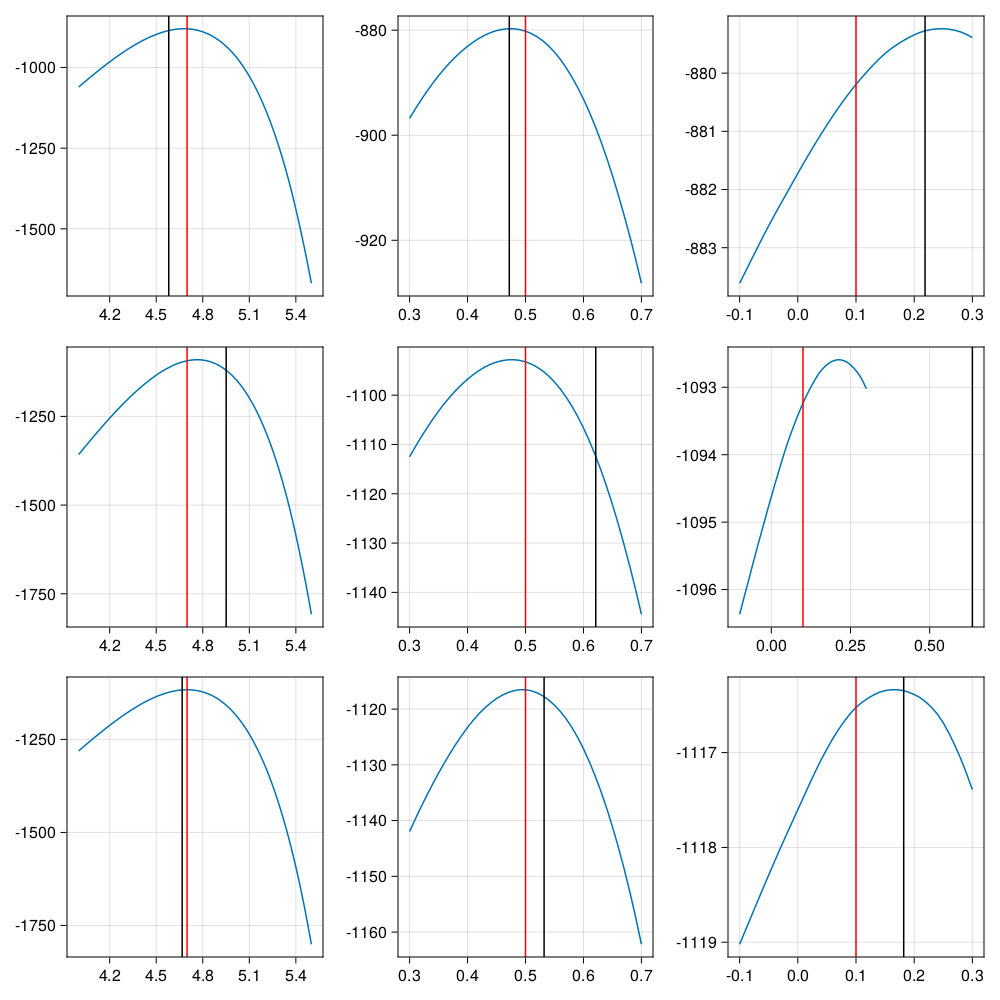

In [43]:
fig = Figure(resolution=(1000, 1000))

for (i, (key, targ)) in enumerate(detectors)

    targets_range = [t for t in targ if norm(t.position .- pos) < 200]
    samples = sample_cascade_event(5E4, theta, phi, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=rng, c_n=c_n)
    hypo = make_cascade_fit_model(seed_x=pos[1], seed_y=pos[2], seed_z=pos[3], seed_time=0.)
    res = min_lh(hypo, samples, targets_range, model, tf_dict)
    minvals = Optim.minimizer(res)


    ax1 = Axis(fig[i, 1])
    llhs = [single_cascade_likelihood(le, theta, phi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict, c_n=c_n) for le in les]
    lines!(ax1, les, llhs)
    vlines!(ax1, [log10(5E4), minvals[1]], color=[:red, :black])


    ax2 = Axis(fig[i, 2])
    llhs = [single_cascade_likelihood(log10(5E4), zen, phi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict, c_n=c_n) for zen in zens]
    lines!(ax2, zens, llhs)
    vlines!(ax2, [theta, minvals[2]], color=[:red, :black])

    ax3 = Axis(fig[i, 3])
    llhs = [single_cascade_likelihood(log10(5E4), theta, azi, pos, 0.; samples=samples, targets=targets_range, model=model, tf_vec=tf_dict, c_n=c_n) for azi in azis]
    lines!(ax3, azis, llhs)
    vlines!(ax3, [phi, minvals[3]], color=[:red, :black])
end

fig

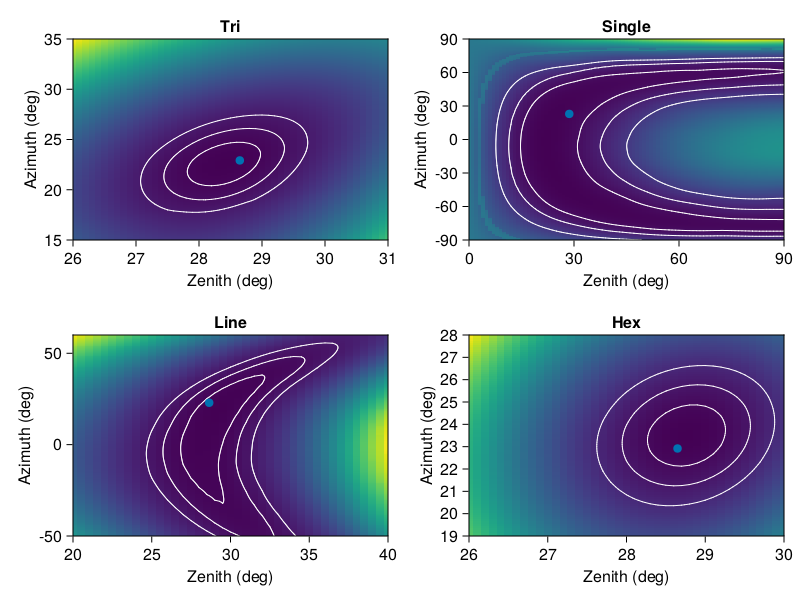

In [40]:
pos = SA[8., -5., -450]
theta = 0.5
phi = 0.4
rng = MersenneTwister(31338)
#targets_range = [target]

axis_ranges = Dict("Tri" => (26, 31, 15, 35, 0.1), "Single" => (0, 90, -90, 90, 1), "Line" => (20, 40, -50, 60, 0.5), "Hex" => (26, 30, 19, 28, 0.1))

levels = map(sigma -> invlogcdf(Chisq(2), log(1-2*ccdf(Normal(), sigma))), [1, 2, 3])


fig = Figure()
ga = fig[1, 1] = GridLayout()

for (i, (dkey, targets)) in enumerate(detectors)

    ranges = axis_ranges[dkey]
    thetas = deg2rad.(ranges[1]:ranges[end]:ranges[2])
    phis = deg2rad.(ranges[3]:ranges[end]:ranges[4])


    targets_range = [t for t in targets if norm(t.position .- pos) < 200]
    data = sample_cascade_event(5E4, theta, phi, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=rng, c_n=c_n)
    
    llh2d = single_cascade_likelihood.(log10(5E4), thetas, permutedims(phis), Ref(pos), 0.; data=data, targets=targets_range, model=model, tf_vec=tf_dict, c_n=c_n)
    rellh = maximum(llh2d) .- llh2d
    row, col = divrem(i-1, 2)
    ax = Axis(ga[row+1, col+1], title=dkey, xlabel="Zenith (deg)", ylabel="Azimuth (deg)", limits=ranges[1:4])
    hm = heatmap!(ax, rad2deg.(thetas), rad2deg.(phis), rellh)
    contour!(ax,  rad2deg.(thetas), rad2deg.(phis), rellh, levels=levels, color=:white)
    scatter!(ax, rad2deg(theta), rad2deg(phi))
end
#Colorbar(fig[1, 2], hm)
fig

# Mock Muon

In [30]:


Flux.testmode!(model)

pos = SA[-10., 5., 10.]
targets_range = [t for t in targets if norm(t.position .- pos) < 200]
targets_range = [target]

samples = sample_cascade_event(5E4, 0.2, 0.1, pos, 0.; targets=targets_range, model=model, tf_vec=tf_dict, rng=Random.GLOBAL_RNG)
hypo = make_cascade_fit_model(seed_x=-10., seed_y=10., seed_z=10., seed_time=0.)



res = min_lh(hypo, samples, targets_range, model, tf_dict)
minvals = Optim.minimizer(res)



3-element Vector{Float64}:
 4.866440024474234
 0.06436749890309053
 1.3574762524214475e-5

In [46]:
targets_range = [t for t in targets if norm(t.position .- pos) < 200]
model_res = Dict()
for (mname, model_path) in models
    m = BSON.load(model_path)
    Flux.testmode!(m[:model])
    res = calc_resolution_maxlh(targets_range, m, 200)
    model_res[mname] = res
end

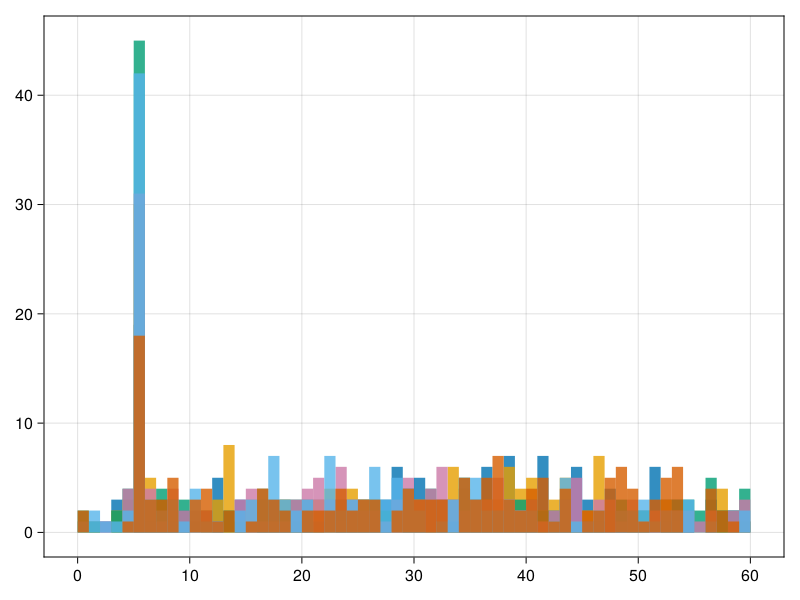

In [48]:
fig = Figure()
ax = Axis(fig[1, 1])

bins = 0:1:60

for (k, v) in model_res

    hist!(ax, rad2deg.(acos.(dot.(sph_to_cart.(v[2, :], v[3, :]), Ref(sph_to_cart(0.1, 0.1))))),
    label=k, bins=bins)

end
fig